In [52]:
from os import path
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd

import numpy as np

from datetime import datetime, timezone
from dateutil import tz
import pytz

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

In [53]:
df = pd.read_csv("wattime_data.csv")
df["date"] = pd.to_datetime(df.point_time)
df["date_PT"] = pd.DatetimeIndex(df['date']).tz_convert("America/Los_Angeles")
df = df.drop(columns="date")
df["time"] = pd.DatetimeIndex(df['date_PT']).time
df["year"] = [d.year for d in df["date_PT"]]
df["month"] = [d.month for d in df["date_PT"]]
df["day_of_month"] = pd.DatetimeIndex(df['date_PT']).day
df["day_of_week"] = [datetime.weekday(d) for d in df["date_PT"]]
df["day_of_week"] = df["day_of_week"].replace({0 : "Mon", 1 : "Tue", 2 : "Wed", 3 : "Thu", 4 : "Fri", 5 : "Sat", 6 : "Sun"})
df["hour"] = [d.hour for d in df["time"]]
df["minute"] = [d.hour * 60 + d.minute for d in df["time"]]
df = df.drop("Unnamed: 0", axis=1)
df = df.drop("point_time", axis=1)
df = df.rename(columns = {"value" : "MOER"})
# 30 minute rolling average of MOER
df["MOER_rolling"] = df['MOER'].rolling(6).mean()
df = df[df["year"] != 2017]
df = df.reset_index()

hour_averages = []
for i in range(0, len(df), 12):
    avg = np.mean(df["MOER"].iloc[i:i+12])
    hour_averages += [avg] * 12

df["MOER_hourly_average"] = hour_averages[:len(df)]

df

,index,MOER,frequency,market,ba,datatype,version,date_PT,time,year,month,day_of_month,day_of_week,hour,minute,MOER_rolling,MOER_hourly_average
0,96,1010.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2018-01-01 00:00:00-08:00,00:00:00,2018,1,1,Mon,0,0,1010.666667,1019.416667
1,97,1010.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2018-01-01 00:00:00-08:00,00:00:00,2018,1,1,Mon,0,0,1012.333333,1019.416667
2,98,1025.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2018-01-01 00:05:00-08:00,00:05:00,2018,1,1,Mon,0,5,1015.000000,1019.416667
3,99,1024.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2018-01-01 00:10:00-08:00,00:10:00,2018,1,1,Mon,0,10,1017.500000,1019.416667
4,100,1023.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2018-01-01 00:15:00-08:00,00:15:00,2018,1,1,Mon,0,15,1017.666667,1019.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499091,499187,920.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 19:10:00-07:00,19:10:00,2022,9,29,Thu,19,1150,918.000000,915.666667
499092,499188,918.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 19:15:00-07:00,19:15:00,2022,9,29,Thu,19,1155,918.500000,917.500000
499093,499189,918.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 19:20:00-07:00,19:20:00,2022,9,29,Thu,19,1160,919.000000,917.500000
499094,499190,917.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-09-29 19:25:00-07:00,19:25:00,2022,9,29,Thu,19,1165,919.333333,917.500000


## Looking at the distribution of MOER Values

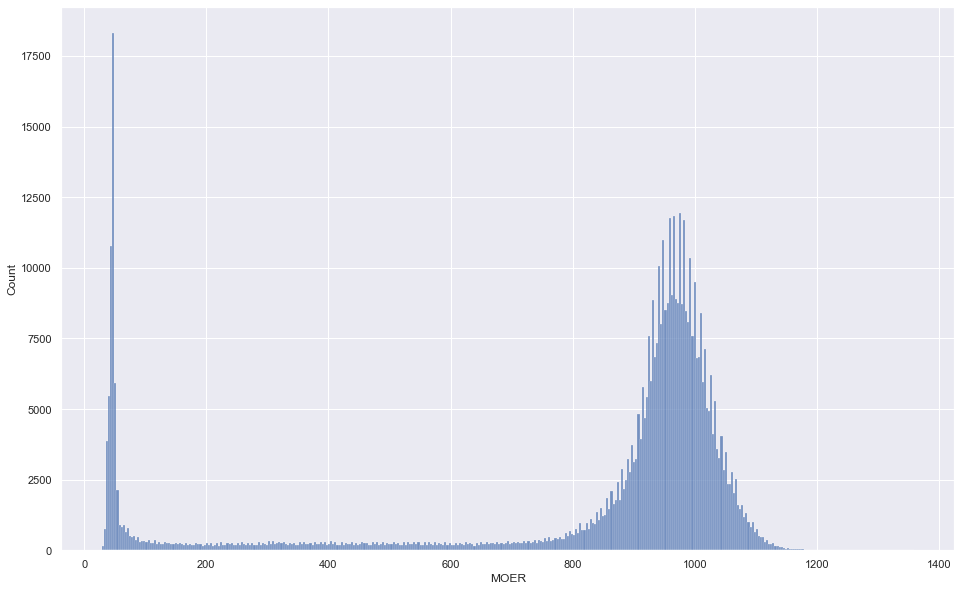

In [54]:
sns.set(rc={'figure.figsize':(16, 10)});
sns.histplot(data=df, x="MOER");

## Looking at MOERs by Day of Week
- Noticable drop during the weekends. 
- Monday and Friday are the lowest weekdays, which also makes sense (3-day weekends)

In [55]:
by_dow = df[["day_of_week", "MOER"]].groupby("day_of_week").mean()
by_dow = by_dow.reindex(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
by_dow

,MOER
day_of_week,
Mon,827.732295
Tue,835.494358
Wed,834.459318
Thu,834.194287
Fri,826.213971
Sat,780.411397
Sun,765.058075


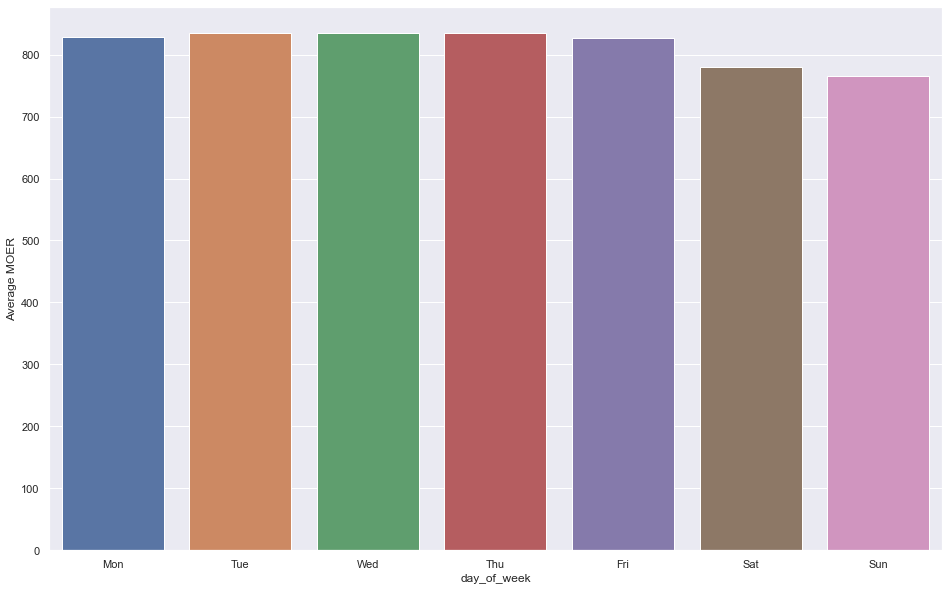

In [56]:
sns.barplot(data=by_dow, x=by_dow.index, y="MOER")
plt.ylabel("Average MOER");

## Looking at most polluting hours of the week.
* Looking at waking hours 8am - midnight

In [57]:
df_hourly_waking = df[(df["minute"] % 60 == 0) & (~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7]))]
df_hourly = df[(df["minute"] % 60 == 0)]

In [58]:
by_hour_of_week = df_hourly.groupby(["day_of_week", "hour"])[["MOER"]].mean()
by_hour_of_week.sort_values("MOER").head(20)

MOER
day_of_week hour            
Sun         11    422.234818
            10    424.174089
            9     434.550607
            12    441.983806
            13    442.781377
Sat         11    459.473684
            12    464.931174
            13    471.105263
Sun         14    475.141700
Sat         10    481.493927
            9     483.995951
            14    507.882591
            15    536.064777
Sun         15    536.789474
            8     560.566802
Mon         13    575.983871
Fri         12    576.821862
Mon         10    595.370968
Fri         13    596.315789
Sat         8     597.923077

In [59]:
by_hour_of_week.sort_values("MOER", ascending=True).sort_values("MOER", ascending=False).head(20)

,,MOER
day_of_week,hour,
Wed,4,987.250000
Sun,5,985.975709
Thu,5,984.133065
Sat,5,983.611336
Thu,4,982.298387
Tue,4,982.052419
Wed,5,981.629032
Sun,4,981.578947
Tue,5,981.084677


In [60]:
def get_percentile_by_hour_of_week(percentile, waking_hours_only=True):
    if waking_hours_only:
        cutoff = np.percentile(df[~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]["MOER_hourly_average"], percentile)
        output = df_hourly_waking[df["MOER_hourly_average"] > cutoff].groupby(["hour", "day_of_week"])[["MOER_hourly_average"]].count()
        return output.sort_values("MOER_hourly_average", ascending=False)
    else:
        cutoff = np.percentile(df["MOER_hourly_average"], percentile)
        output = df_hourly[df["MOER_hourly_average"] > cutoff].groupby(["hour", "day_of_week"])[["MOER_hourly_average"]].count()
        return output.sort_values("MOER_hourly_average", ascending=False)

# In the following analysis I consider waking hours (8am-11pm)

## Number of 90th+ Percentile Readings by Hour of the Week

In [61]:
get_percentile_by_hour_of_week(90).head(20)

MOER_hourly_average
hour day_of_week                     
20   Mon                           52
19   Mon                           50
     Wed                           50
20   Thu                           50
     Tue                           50
     Wed                           49
21   Tue                           48
19   Thu                           47
16   Mon                           46
21   Mon                           46
19   Tue                           45
18   Wed                           45
17   Mon                           44
21   Wed                           42
16   Thu                           42
19   Sat                           42
16   Fri                           42
21   Thu                           41
18   Mon                           41
     Thu                           40

## Number of 95th+ Percentile Readings by Hour of the Week

In [62]:
get_percentile_by_hour_of_week(95).head(20)

,,MOER_hourly_average
hour,day_of_week,
18,Wed,29
19,Mon,27
20,Thu,26
21,Mon,26
20,Mon,26
18,Mon,26
19,Wed,25
18,Thu,24
20,Wed,24


## Number of 99th+ Percentile Readings by Hour of the Week

In [63]:
get_percentile_by_hour_of_week(99).head(20)

MOER_hourly_average
hour day_of_week                     
19   Wed                           10
15   Wed                            9
19   Mon                            8
20   Wed                            8
15   Sun                            7
     Mon                            7
20   Fri                            7
19   Sat                            7
15   Tue                            7
     Sat                            6
23   Sun                            6
19   Fri                            6
15   Thu                            6
19   Tue                            6
20   Thu                            6
     Mon                            5
     Tue                            5
19   Thu                            5
16   Tue                            5
19   Sun                            5

# Considering all Hours

In [64]:
percentile_tbl = get_percentile_by_hour_of_week(99, waking_hours_only=True).head(20)
percentile_tbl["Percentage of Days"] = percentile_tbl["MOER_hourly_average"] / 2.47
percentile_tbl = percentile_tbl.drop(columns=["MOER_hourly_average"])
percentile_tbl

Percentage of Days
hour day_of_week                    
19   Wed                    4.048583
15   Wed                    3.643725
19   Mon                    3.238866
20   Wed                    3.238866
15   Sun                    2.834008
     Mon                    2.834008
20   Fri                    2.834008
19   Sat                    2.834008
15   Tue                    2.834008
     Sat                    2.429150
23   Sun                    2.429150
19   Fri                    2.429150
15   Thu                    2.429150
19   Tue                    2.429150
20   Thu                    2.429150
     Mon                    2.024291
     Tue                    2.024291
19   Thu                    2.024291
16   Tue                    2.024291
19   Sun                    2.024291

## Finding High Emissions Periods

In [65]:
def get_extreme_peaks_by_percentile(percentile, waking_hours_only=False, rolling=True, datatype="MOER"):  
    """
    Returns all extreme peaks where the peak MOER is in the specified percentile of all MOER data
    
    percentile - int in [0, 100] that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = df[~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = df
    
    data = data.reset_index(drop=True)

    
    if datatype == "MOER":
        moers = data["MOER"]
    elif datatype == "MOER_rolling":
        moers = data["MOER_rolling"]
    elif datatype == "MOER_hourly_average":
        data = data.iloc[::12, :]
        data = data.reset_index(drop=True)
        moers = data["MOER_hourly_average"]
    
    cutoff = np.percentile(moers, percentile)
    peak_indices = []
    for i in range(1, len(moers)):
        if moers[i] >= cutoff and moers[i-1] < moers[i] and moers[i+1] < moers[i]:
            peak_indices.append(i)
            
    return data.iloc[peak_indices]

In [66]:
def get_extreme_peaks_by_value(cutoff, waking_hours_only=False, datatype="MOER"):  
    """
    Returns all extreme peaks where the peak MOER is in the specified cutoff of all MOER data
    
    percentile - MOER cutoff that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = df[~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = df
    
    data = data.reset_index(drop=True)

    
    if datatype == "MOER":
        moers = data["MOER"]
    elif datatype == "MOER_rolling":
        moers = data["MOER_rolling"]
    elif datatype == "MOER_hourly_average":
        data = data.iloc[::12, :]
        data = data.reset_index(drop=True)
        moers = data["MOER_hourly_average"]
    
    peak_indices = []
    for i in range(1, len(moers)):
        if moers[i] >= cutoff and moers[i-1] < moers[i] and moers[i+1] < moers[i]:
            peak_indices.append(i)
            
    return data.iloc[peak_indices]

In [67]:
def get_top_n_peaks(n, waking_hours_only=False, datatype="MOER"):  
    """
    Returns all extreme peaks where the peak MOER is in the specified cutoff of all MOER data
    
    percentile - MOER cutoff that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = df[~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = df
    
    data = data.reset_index(drop=True)
        
    if datatype == "MOER":
        moers = data["MOER"]
    elif datatype == "MOER_rolling":
        moers = data["MOER_rolling"]
    elif datatype == "MOER_hourly_average":
        data = data.iloc[::12, :]
        data = data.reset_index(drop=True)
        moers = data["MOER_hourly_average"]
    
    return get_extreme_peaks_by_percentile(90, waking_hours_only, datatype).sort_values(by=[datatype], ascending=False).iloc[:n, :]

In [68]:
top_100 = get_top_n_peaks(100, waking_hours_only=True, datatype="MOER")
top_100["year_frac"] = top_100["month"] + top_100["day_of_month"] / 30

In [69]:
top_100

,index,MOER,frequency,market,ba,datatype,version,date_PT,time,year,month,day_of_month,day_of_week,hour,minute,MOER_rolling,MOER_hourly_average,year_frac
288863,433489,1358.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-02-13 15:55:00-08:00,15:55:00,2022,2,13,Sun,15,955,836.166667,1092.000000,2.433333
205535,308483,1283.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2020-12-06 15:55:00-08:00,15:55:00,2020,12,6,Sun,15,955,1124.000000,1086.583333,12.200000
206874,310494,1280.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2020-12-13 15:30:00-08:00,15:30:00,2020,12,13,Sun,15,930,1249.000000,1257.000000,12.433333
206876,310496,1280.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2020-12-13 15:40:00-08:00,15:40:00,2020,12,13,Sun,15,940,1274.333333,1257.000000,12.433333
206871,310491,1278.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2020-12-13 15:15:00-08:00,15:15:00,2020,12,13,Sun,15,915,1216.833333,1257.000000,12.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204983,307643,1174.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2020-12-03 17:55:00-08:00,17:55:00,2020,12,3,Thu,17,1075,1088.500000,1062.750000,12.100000
69061,103729,1174.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2018-12-26 19:05:00-08:00,19:05:00,2018,12,26,Wed,19,1145,1066.000000,1077.666667,12.866667
209183,313955,1174.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2020-12-25 15:55:00-08:00,15:55:00,2020,12,25,Fri,15,955,1127.000000,930.916667,12.833333
76698,115208,1174.0,NaN,RTM,CAISO_NORTH,MOER,3.0,2019-02-04 15:30:00-08:00,15:30:00,2019,2,4,Mon,15,930,1119.166667,1116.000000,2.133333


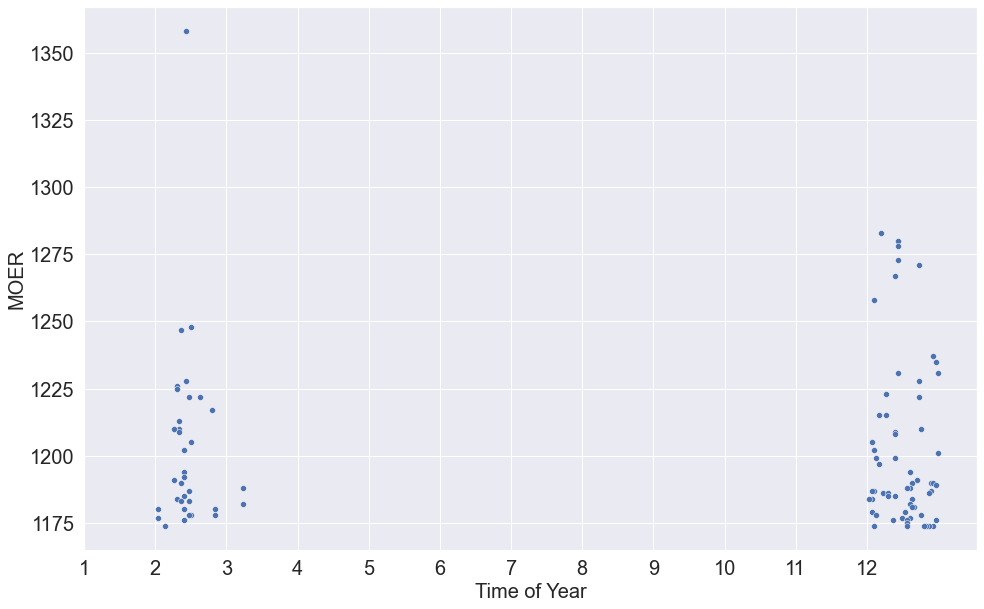

In [70]:
sns.scatterplot(x=top_100["year_frac"], y=top_100["MOER"])
plt.xticks(range(1, 13, 1), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time of Year", fontsize=20)
plt.ylabel("MOER", fontsize=20)
plt.show()

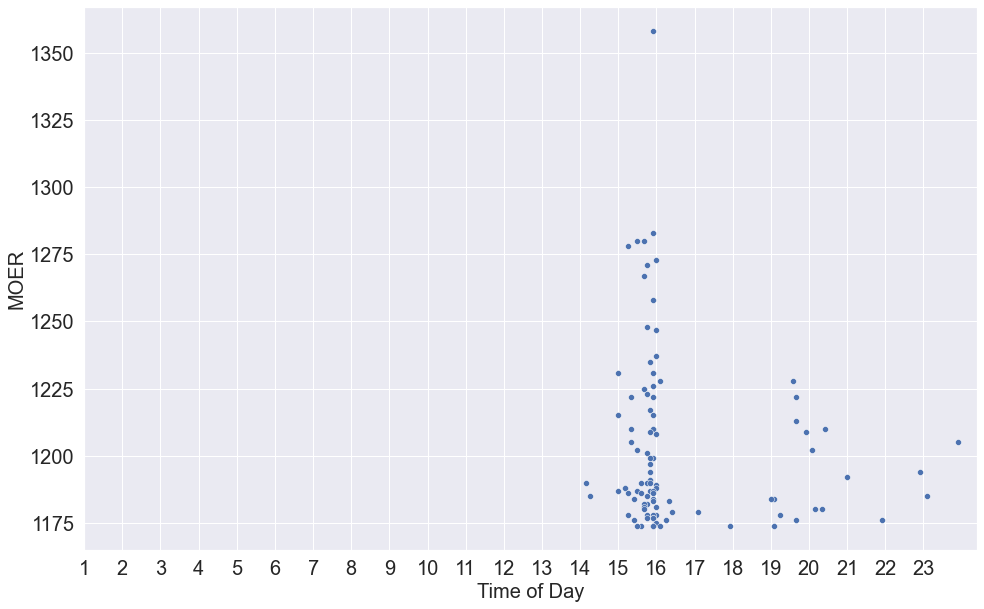

In [71]:
sns.scatterplot(x=top_100["minute"]/60, y=top_100["MOER"])
plt.xticks(range(1, 24, 1), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time of Day", fontsize=20)
plt.ylabel("MOER", fontsize=20)
plt.show()

In [72]:
def get_top_n_extreme_intervals(n, percent_reduction_from_peak, waking_hours_only=False, datatype="MOER"):
    """
    Returns a table with information about the n most extreme peaks (by smoothed MOER value). 
        The interval is categorized as the time from the peak to the specified percent reduction from the peak
    
    n - how many intervals to return
    percent_reduction_from_peak - percent reduction from the peak that determines the end of the interval
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = df[~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = df
    
    data = data.reset_index(drop=True)
        
    if datatype == "MOER":
        moers = data["MOER"]
    elif datatype == "MOER_rolling":
        moers = data["MOER_rolling"]
    elif datatype == "MOER_hourly_average":
        data = data.iloc[::12, :]
        data = data.reset_index(drop=True)
        moers = data["MOER_hourly_average"]
    
    intervals = pd.DataFrame(columns=["peak_time", "end_time", "peak_MOER"])
    peaks = get_extreme_peaks_by_value(750, waking_hours_only=waking_hours_only)
    
    for i in peaks.index:
        peak = peaks[datatype][i]
        goal = peak * (1 - percent_reduction_from_peak / 100)
        
        end_index = i
        while end_index < len(data) - 1 and data[datatype][end_index] > goal:
            end_index += 1
            
        peak_time = data["date_PT"][i]
        end_time = data["date_PT"][end_index]
        
        intervals.loc[len(intervals)] = [peak_time, end_time, peak]

    intervals["duration"] = intervals["end_time"] - intervals["peak_time"]
    intervals["duration"] = [td.seconds / 3600 for td in intervals["duration"]]
    return intervals.sort_values("peak_MOER", ascending=False).head(n)
        

In [73]:
top_100_10_percent = get_top_n_extreme_intervals(100, 10, waking_hours_only=True, datatype="MOER_rolling")
top_100_10_percent.sort_values("duration", ascending=False)

KeyboardInterrupt: 

In [ ]:
ax = sns.histplot(data=top_100_10_percent, x="duration", stat="count", binwidth=0.5, binrange=[0, 10]);
ax.set(xticks=range(0, 11))
ax.set(title="")
ax.set_ylabel("Count", fontsize = 20)
ax.set_xlabel("Duration from Peak to 10% Cooldown (hours)", fontsize = 20)
ax.set_title("Distribution of Duration from Peak to 10% Cooldown of Top 100 Peaks by MOER, 2018-2022", fontsize=20)
ax;

In [ ]:
top_100_20_percent = get_top_n_extreme_intervals(100, 20, waking_hours_only=True, datatype="MOER")
top_100_20_percent.sort_values("duration", ascending=False)

In [ ]:
ax = sns.histplot(data=top_100_20_percent, x="duration", stat="count", binwidth=0.5, binrange=[0, 20]);
ax.set(xticks=range(0, 21))
ax.set(title="")
ax.set_ylabel("Count", fontsize = 20)
ax.set_xlabel("Duration from Peak to 20% Cooldown (hours)", fontsize = 20)
ax.set_title("Distribution of Duration from Peak to 20% Cooldown of Top 100 Peaks by MOER, 2018-2022", fontsize=20)
ax;

In [ ]:
top_100_30_percent = get_top_n_extreme_intervals(100, 30, waking_hours_only=True, datatype="MOER")
top_100_30_percent.sort_values("duration", ascending=False)

In [ ]:
ax = sns.histplot(data=top_100_30_percent, x="duration", stat="count", binwidth=0.5, binrange=[0, 23]);
ax.set(title="")
ax.set_ylabel("Count", fontsize = 20)
ax.set_xlabel("Duration from Peak to 30% Cooldown (hours)", fontsize = 20)
ax.set_title("Distribution of Duration from Peak to 30% Cooldown of Top 100 Peaks by MOER, 2018-2022", fontsize=20)
ax;

In [ ]:
top_100_50_percent = get_top_n_extreme_intervals(100, 50, waking_hours_only=True, datatype="MOER")
top_100_50_percent.sort_values("duration", ascending=False)

In [ ]:
ax = sns.histplot(data=top_100_50_percent, x="duration", stat="percent", binwidth=0.5, binrange=[0, 24]);
ax.set(xticks=range(0, 25))
ax.set(title="")
ax.set_ylabel("count", fontsize = 20)
ax.set_xlabel("Duration from Peak to 50% Cooldown (hours)", fontsize = 20)
ax.set_title("Distribution of Duration from Peak to 50% Cooldown of Top 100 Peaks by MOER, 2018-2022", fontsize=20)
ax;

In [ ]:
top_100_10_percent_rolling = get_top_n_extreme_intervals(100, 10, waking_hours_only=True, datatype="MOER_rolling")
top_100_10_percent_rolling.sort_values("duration", ascending=False)

In [ ]:
top_100_20_percent_rolling = get_top_n_extreme_intervals(100, 20, waking_hours_only=True, datatype="MOER_rolling")
top_100_20_percent_rolling.sort_values("duration", ascending=False)

In [ ]:
top_100_30_percent_rolling = get_top_n_extreme_intervals(100, 30, waking_hours_only=True, datatype="MOER_rolling")
top_100_30_percent_rolling.sort_values("duration", ascending=False)

In [ ]:
top_100_50_percent_rolling = get_top_n_extreme_intervals(100, 50, waking_hours_only=True, datatype="MOER_rolling")
top_100_50_percent_rolling.sort_values("duration", ascending=False)

In [ ]:
ax = sns.histplot(data=top_100_10_percent_rolling, x="duration", stat="percent", binwidth=0.5, binrange=[0, 24]);
ax.set(xticks=range(0, 25))
ax.set(title="")
ax.set_ylabel("Count", fontsize = 20)
ax.set_xlabel("Duration from Peak to 10% Cooldown (hours)", fontsize = 20)
ax.set_title("Distribution of Duration from Peak to 10% Cooldown of Top 100 Peaks by rolling MOER, 2018-2022", fontsize=20)
ax;

In [78]:
def get_extreme_peaks_by_percentile_by_year(percentile, year, waking_hours_only=False, rolling=True, datatype="MOER"):  
    """
    Returns all extreme peaks where the peak MOER is in the specified percentile of all MOER data
    
    percentile - int in [0, 100] that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = df[~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = df
        
    data = data[data["year"] == year]
    
    data = data.reset_index(drop=True)

    
    if datatype == "MOER":
        moers = data["MOER"]
    elif datatype == "MOER_rolling":
        moers = data["MOER_rolling"]
    elif datatype == "MOER_hourly_average":
        data = data.iloc[::12, :]
        data = data.reset_index(drop=True)
        moers = data["MOER_hourly_average"]
    
    cutoff = np.percentile(moers, percentile)
    peak_indices = []
    for i in range(1, len(moers)):
        if moers[i] >= cutoff and moers[i-1] < moers[i] and moers[i+1] < moers[i]:
            peak_indices.append(i)
            
    return data.iloc[peak_indices]

In [79]:
def get_top_n_peaks_by_year(n, year, waking_hours_only=False, datatype="MOER"):  
    """
    Returns all extreme peaks where the peak MOER is in the specified cutoff of all MOER data
    
    percentile - MOER cutoff that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = df[~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = df
        
    data = data[data["year"] == year]
    
    data = data.reset_index(drop=True)
        
    if datatype == "MOER":
        moers = data["MOER"]
    elif datatype == "MOER_rolling":
        moers = data["MOER_rolling"]
    elif datatype == "MOER_hourly_average":
        data = data.iloc[::12, :]
        data = data.reset_index(drop=True)
        moers = data["MOER_hourly_average"]
    
    return get_extreme_peaks_by_percentile_by_year(90, year, waking_hours_only, datatype).sort_values(by=[datatype], ascending=False).iloc[:n, :]

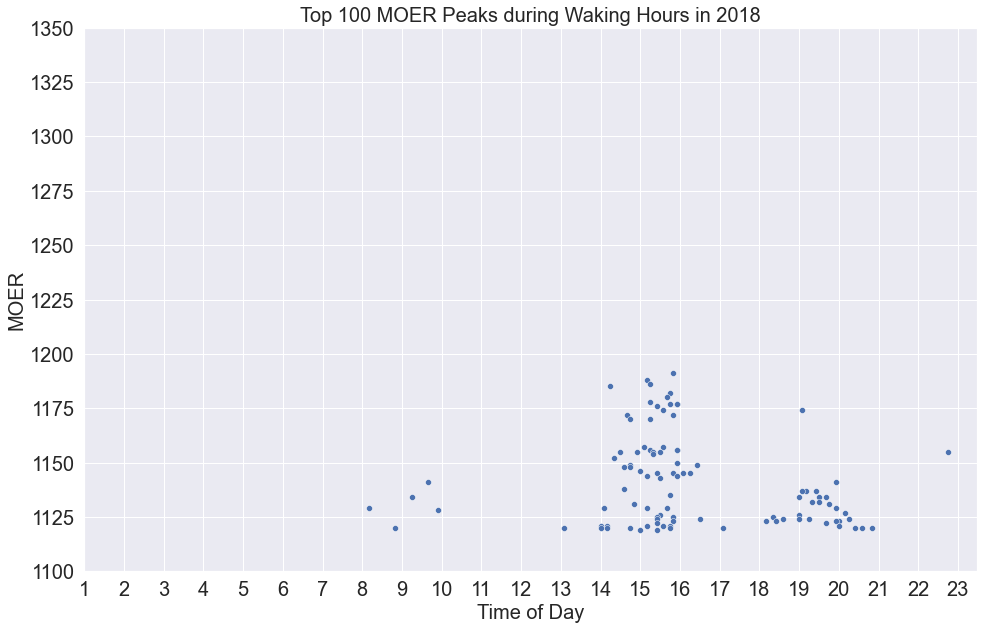

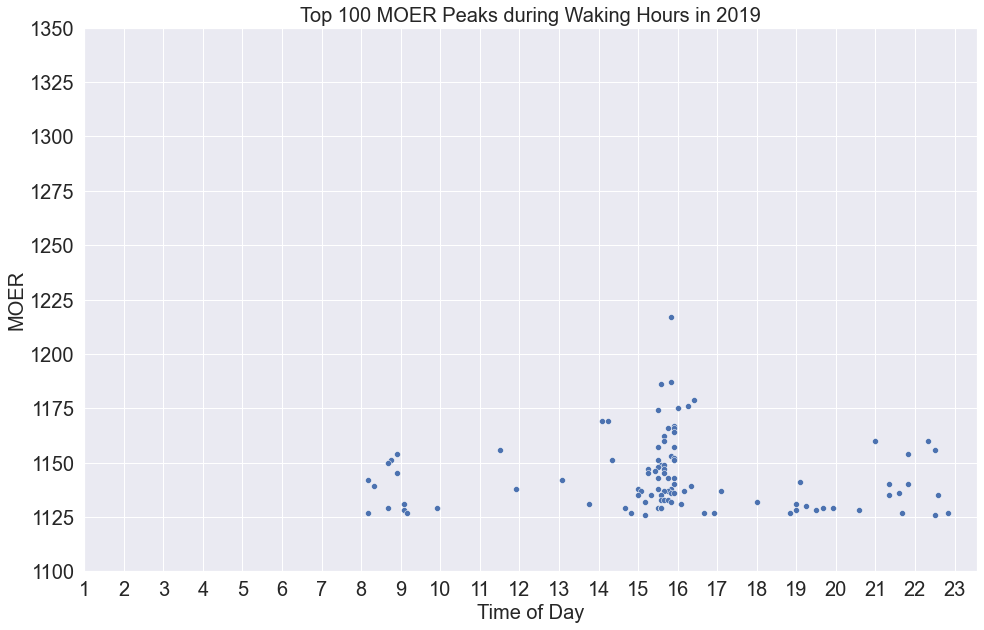

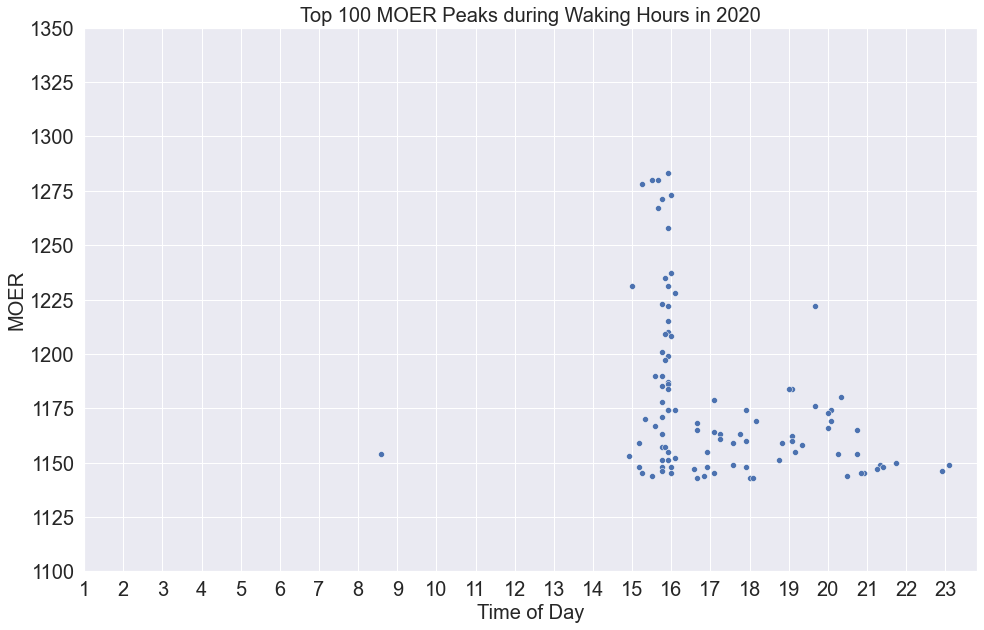

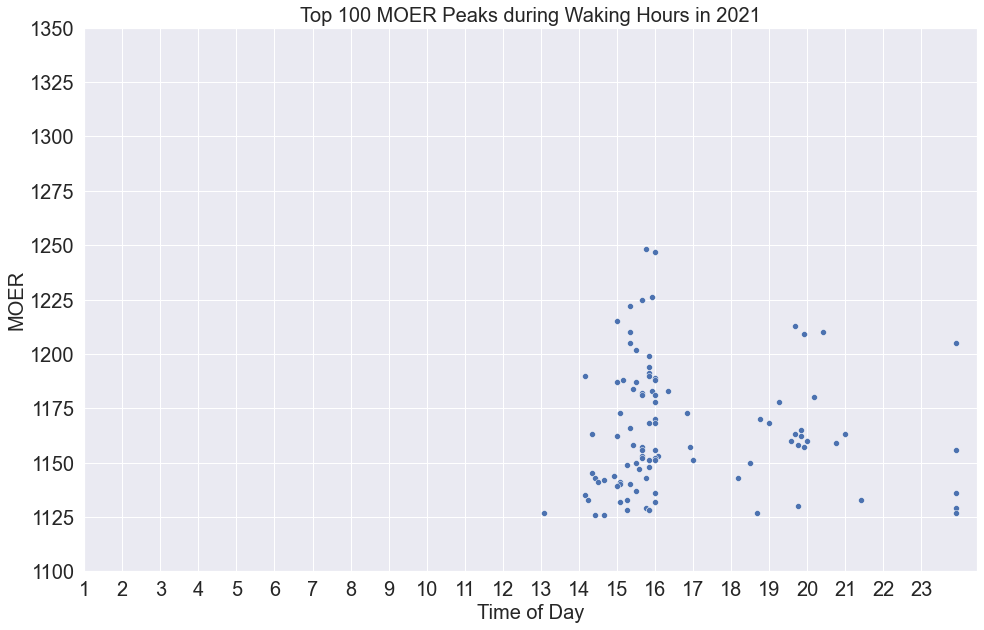

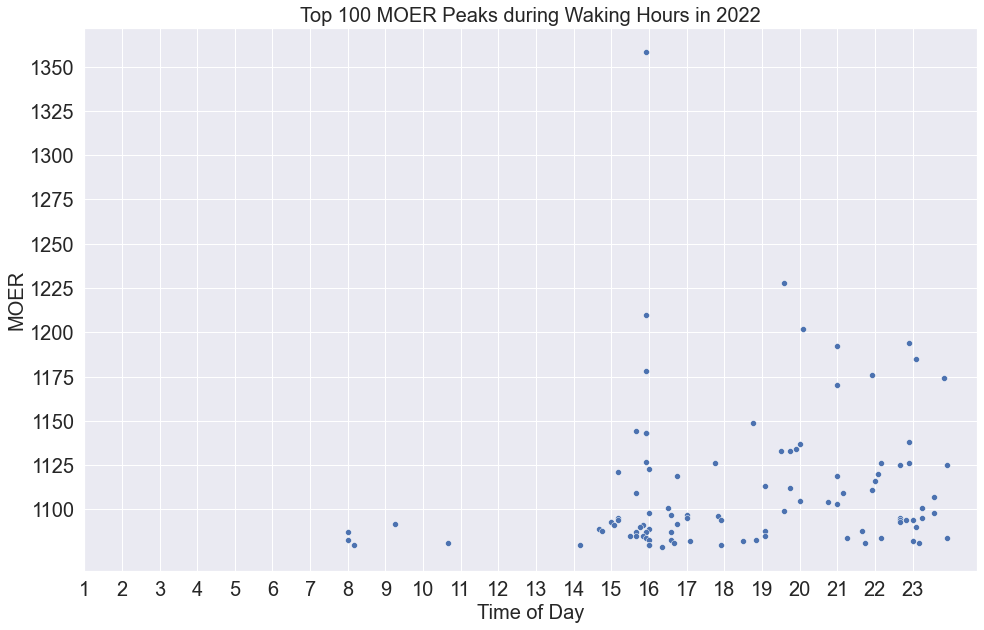

In [85]:
for yr in range(2018, 2023):
    tbl = get_top_n_peaks_by_year(100, yr, waking_hours_only=True)
    sns.scatterplot(x=tbl["minute"]/60, y=tbl["MOER"])
    plt.xticks(range(1, 24, 1), fontsize=20)
    plt.yticks(range(1100, 1375, 25), fontsize=20)
    plt.xlabel("Time of Day", fontsize=20)
    plt.ylabel("MOER", fontsize=20)
    plt.title("Top 100 MOER Peaks during Waking Hours in " + str(yr), fontsize=20)
    plt.show()

In [87]:
tbl

,index,MOER,frequency,market,ba,datatype,version,date_PT,time,year,month,day_of_month,day_of_week,hour,minute,MOER_rolling,MOER_hourly_average
8351,433489,1358.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-02-13 15:55:00-08:00,15:55:00,2022,2,13,Sun,15,955,836.166667,1092.000000
8395,433533,1228.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-02-13 19:35:00-08:00,19:35:00,2022,2,13,Sun,19,1175,1220.666667,1183.333333
7391,432049,1210.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-02-08 15:55:00-08:00,15:55:00,2022,2,8,Tue,15,955,714.666667,880.583333
8209,433251,1202.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-02-12 20:05:00-08:00,20:05:00,2022,2,12,Sat,20,1205,1139.666667,1124.416667
8243,433285,1194.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-02-12 22:55:00-08:00,22:55:00,2022,2,12,Sat,22,1375,1117.166667,1117.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026,430012,1080.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-02-01 14:10:00-08:00,14:10:00,2022,2,1,Tue,14,850,1055.000000,999.000000
11424,438099,1080.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-03-01 16:00:00-08:00,16:00:00,2022,3,1,Tue,16,960,1061.000000,856.833333
7106,431668,1080.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-02-07 08:10:00-08:00,08:10:00,2022,2,7,Mon,8,490,959.166667,777.250000
6432,430610,1080.0,300.0,RTM,CAISO_NORTH,MOER,3.0,2022-02-03 16:00:00-08:00,16:00:00,2022,2,3,Thu,16,960,1066.500000,1012.750000


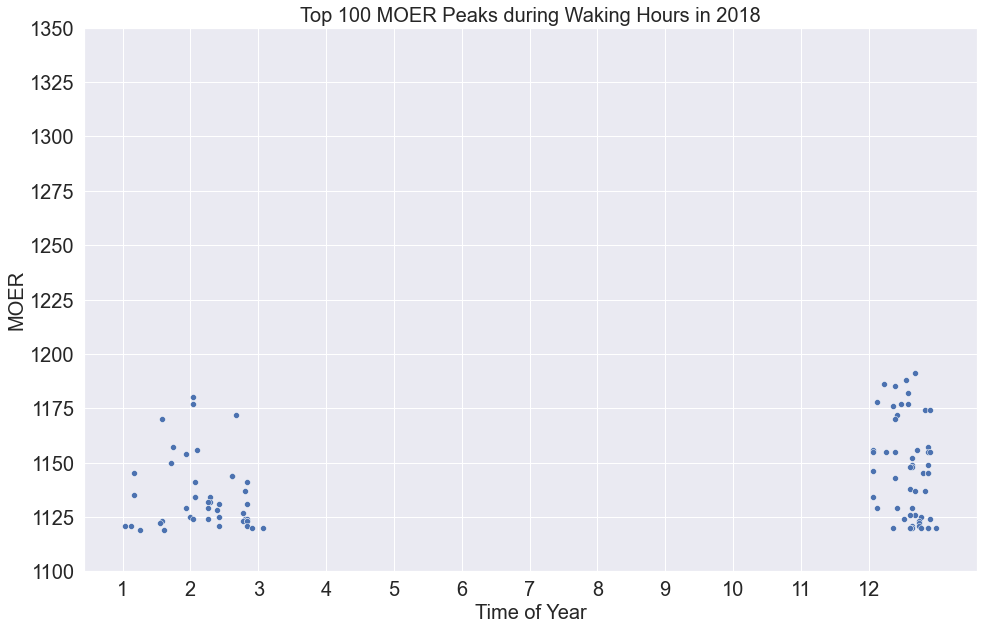

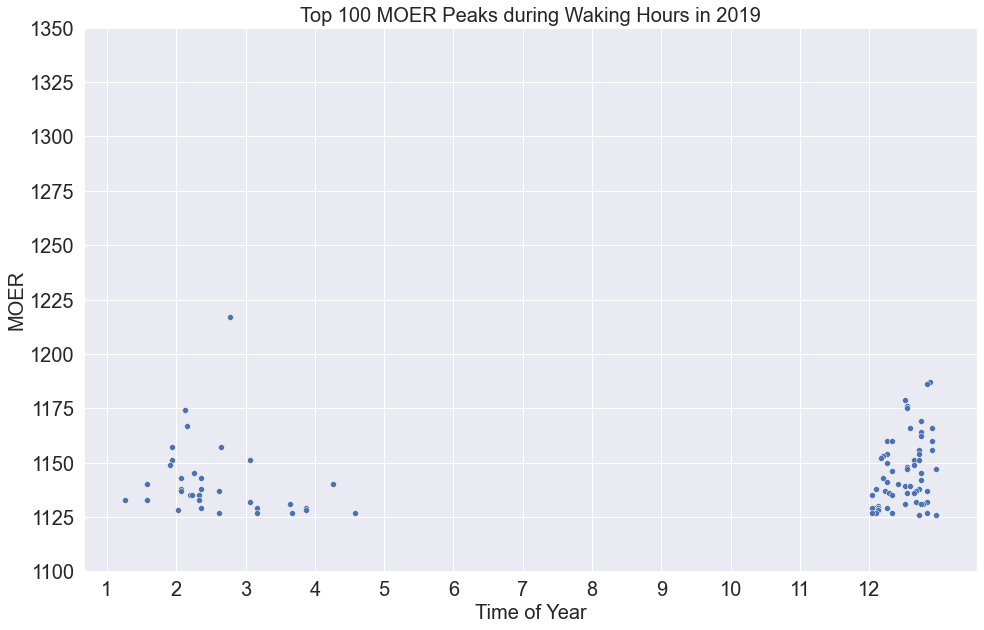

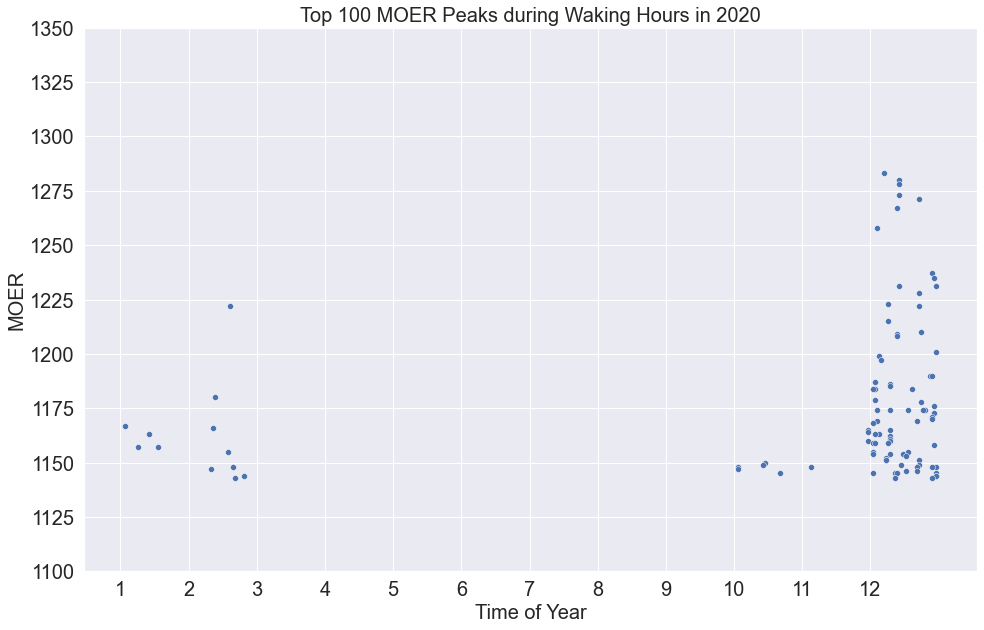

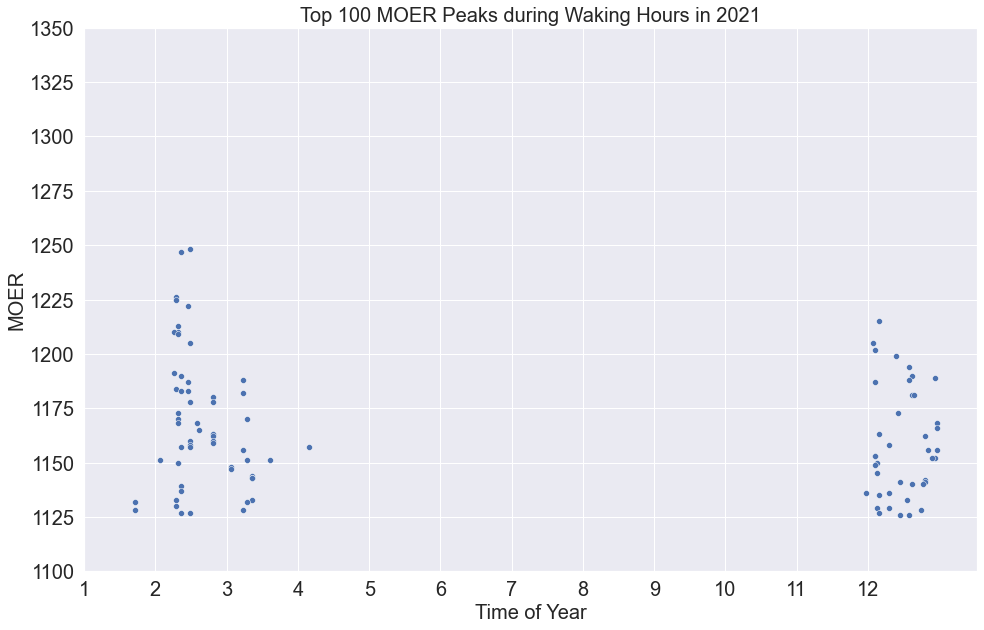

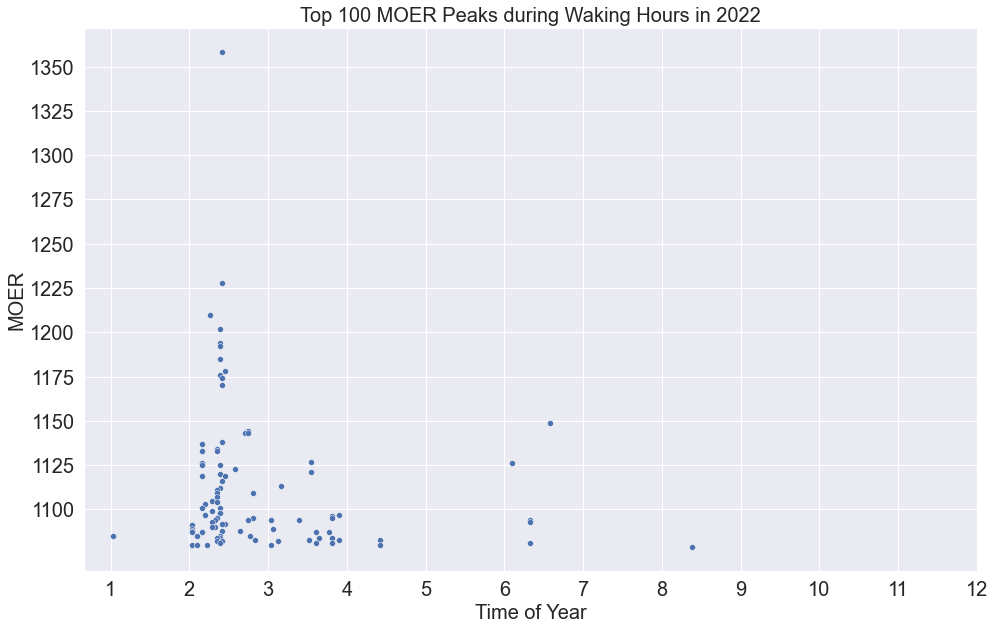

In [92]:
for yr in range(2018, 2023):
    tbl = get_top_n_peaks_by_year(100, yr, waking_hours_only=True)
    sns.scatterplot(x=tbl["month"] + tbl["day_of_month"]/31, y=tbl["MOER"])
    plt.xticks(range(1, 13, 1), fontsize=20)
    plt.yticks(range(1100, 1375, 25), fontsize=20)
    plt.xlabel("Time of Year", fontsize=20)
    plt.ylabel("MOER", fontsize=20)
    plt.title("Top 100 MOER Peaks during Waking Hours in " + str(yr), fontsize=20)
    plt.show()

In [97]:
top_100_2018 = get_top_n_peaks_by_year(100, 2018, waking_hours_only=True)

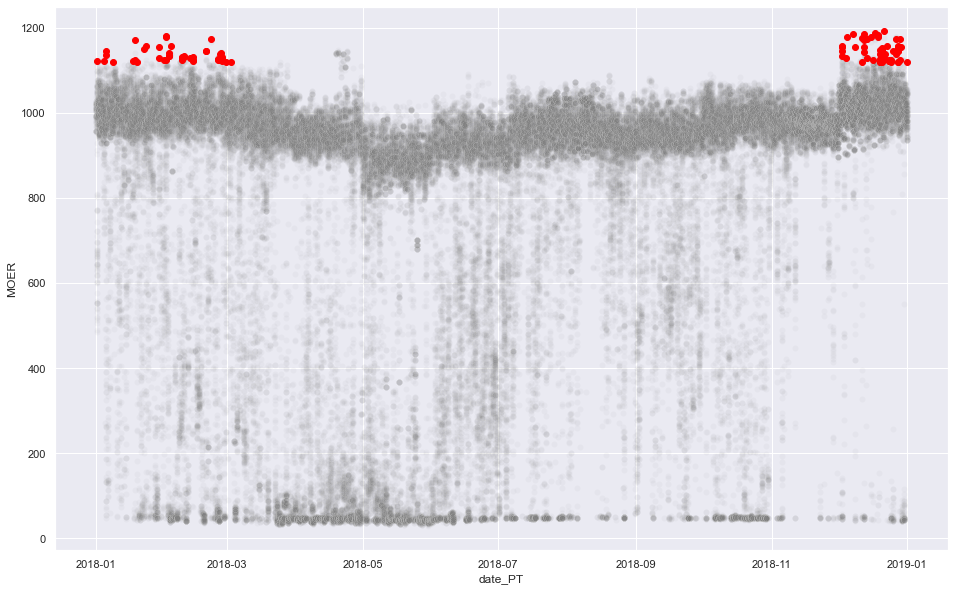

In [103]:
df_2018_waking = df[df["year"] == 2018]
sns.scatterplot(data=df_2018, x="date_PT", y="MOER", alpha=0.05, color='gray')
plt.scatter(x=top_100_2018["date_PT"], y=top_100_2018["MOER"], color="red");

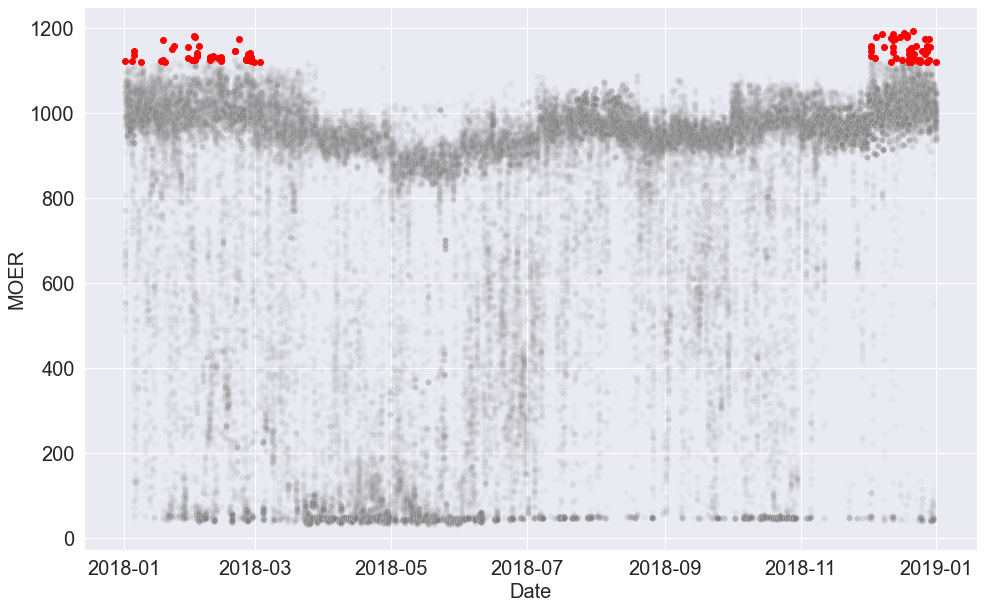

In [108]:
df_2018 = df[~df["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
df_2018 = df_2018[df_2018["year"] == 2018]
sns.scatterplot(data=df_2018, x="date_PT", y="MOER", alpha=0.05, color='gray')
plt.scatter(x=top_100_2018["date_PT"], y=top_100_2018["MOER"], color="red")
plt.xlabel("Date", fontsize=20)
plt.ylabel("MOER", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("peaks_overlaid_2018.png", edgecolor='black', dpi=400, transparent=True);

In [122]:
df_2018["Time"] = df_2018["minute"] / 60
top_100_2018["Time"] = top_100_2018["minute"] / 60

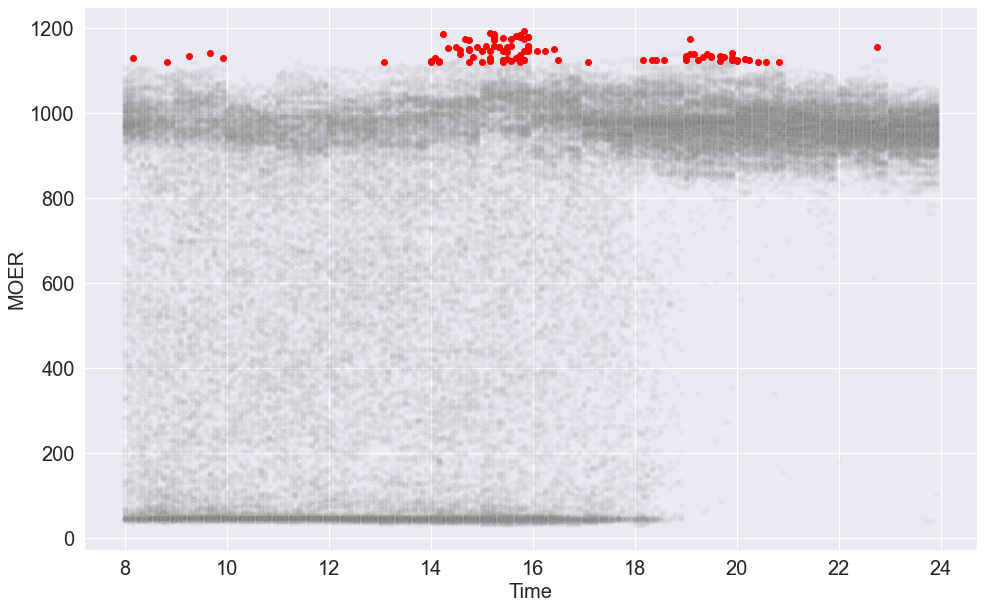

In [126]:
sns.scatterplot(data=df_2018, x="Time", y="MOER", alpha=0.05, color='gray')
plt.scatter(x=top_100_2018["Time"], y=top_100_2018["MOER"], color="red")
plt.xlabel("Time", fontsize=20)
plt.ylabel("MOER", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("peaks_overlaid_daily_2018.png", edgecolor='black', dpi=400, transparent=True);